In [1]:


import tensorflow as tf

import numpy as np
import cupy as cp
import scipy
import scipy.misc  # for imresize

import matplotlib.pyplot as plt
%matplotlib inline

import time

import os # for directory listings
import pickle


/home/n/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

# We can import pre trained data files fro google tensorflow using slim
slim = tf.contrib.slim

from nets import inception
from preprocessing import inception_preprocessing

image_size = inception.inception_v1.default_image_size

IMAGE_W=224
image_size

content_layer = 'Mixed_4b'
style_layers = ['Conv2d_1a_7x7', 'Conv2d_2c_3x3','Mixed_3b','Mixed_4d']
content_w = 0.9
style_w = 12
style_layer_w = [0.5, 1.0, 1.5, 3.0] 
gstep = tf.Variable(0, dtype=tf.int32, 
                                trainable=False, name='global_step')
lr = 0.1


***
***inception_v1*** file is given by tensorflow for using inception model.
we are using inceptionv1 model for this project
inceptionv1.py defines base architecture for the inception model


inception_v1_base() is the function which contains the defined base architecture for the inception model. This can be easily
read as we see this function.

inception_v1 is the actual function to call the inception_v1_base().

inception_v1_base() has architecture that distinguishes the googlenet.
inception_v1() gets the output from the inception_v1_base() and then it is fruther passed for average pooling and so.
This means we can define our own architecture in inception_v1() after getting result from inception_v1_base()

***

***
We also have another important library provided by google that is ***inception_preprocessing***.
This takes care of the data augmentation, and changes that needed to be made in the input tensor.

***

In [3]:


def prep_image(im):
        
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = scipy.misc.imresize(im, (224, int(w*224/h)))
    else:
        im = scipy.misc.imresize(im, (int(h*224/w), 224))

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Now rescale it to [-1,+1].float32 from [0..255].unit8
    im = ( im.astype('float32')/255.0 - 0.5 ) * 2.0
    return rawim, im



In [4]:
photos = "/home/n/projectdl/content2.jpg"
photo_i=-1 # will be incremented in next cell (i.e. to start at [0])

In [5]:


photo_i += 1
photo = plt.imread(photos)
photo_rawim, photo = prep_image(photo)
photo = photo.reshape((1,224,224,3))

/home/n/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [6]:
styles = "/home/n/projectdl/color4.jpg"
style_i=-1 # will be incremented in next cell (i.e. to start at [0])


In [7]:
style_i += 1

style = plt.imread(styles)
style_rawim, style = prep_image(style)
style = style.reshape((1,224,224,3))

/home/n/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [8]:


tf.reset_default_graph()

# This creates an image 'placeholder' - image inputs should be (224,224,3).float32 each [-1.0,1.0]
# input_image_float = tf.placeholder(tf.float32, shape=[1,224, 224, 3], name='input_image_float')
with tf.variable_scope('input') as scope:
            input_image_float = tf.get_variable('in_img', 
                                        shape=([1, 224, 224, 3]),
                                        dtype=tf.float32,
                                        initializer=tf.zeros_initializer())
# Here is the actual model zoo model being instantiated :
with slim.arg_scope(inception.inception_v1_arg_scope()):
    _, end_points = inception.inception_v1(input_image_float, num_classes=1001, is_training=False)

# Create an operation that loads the pre-trained model from the checkpoint
init_fn = slim.assign_from_checkpoint_fn(
    os.path.join('home/n/models/inception_/', '/home/n/data/inception_v1.ckpt'),
    slim.get_model_variables('InceptionV1')
)



In [9]:


with tf.Session() as sess:
    # This is the loader 'op' we defined above
    init_fn(sess)  
    sess.run(input_image_float.assign(photo))
    # This run grabs all the layer constants for the original photo image input
    photo_layers_np = sess.run([ end_points[content_layer]])
    

    # This run grabs all the layer constants for the style image input
with tf.Session() as sess:
    init_fn(sess)
    sess.run(input_image_float.assign(style))
    style_layers_np = sess.run([ end_points[k] for k in style_layers])
    

INFO:tensorflow:Restoring parameters from /home/n/data/inception_v1.ckpt
INFO:tensorflow:Restoring parameters from /home/n/data/inception_v1.ckpt


In [10]:
def gram_matrix(tensor,ch):
    

    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, ch])
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)
    return gram

def content_loss(P, X, layer):
    p = tf.constant( P)
    x = X[layer]
    
    loss = 1./4. * tf.reduce_mean(tf.square(x - p))
    return loss

def style_loss(S, X, layer):
    s = S
    x = X[layer]
    layer_shape = x.get_shape()
    N = layer_shape[1]
    M = layer_shape[2] * layer_shape[3]
    
    S_gram = gram_matrix(s,layer_shape[3])
    X_gram = gram_matrix(x,layer_shape[3])
    
    
    
    loss = tf.reduce_mean(tf.square(X_gram - S_gram)) / (4. * tf.cast( tf.square(N) * tf.square(M), tf.float32))
    return loss



In [11]:
sl = style_loss(style_layers_np[0], end_points, 'Conv2d_1a_7x7') + 5*style_loss(style_layers_np[1], end_points, 'Conv2d_2c_3x3') + style_loss(style_layers_np[2], end_points, 'Mixed_3b') + style_loss(style_layers_np[3], end_points, 'Mixed_4d')

In [12]:
cl = content_loss(photo_layers_np[0],end_points,content_layer)

In [13]:
total_loss = sl*15 + cl*10

In [14]:
# # And here are some more TF nodes, to compute the losses using the layer values 'saved off' earlier
# losses = []

# # content loss
# cl = 10.
# losses.append(cl *1.     * content_loss(photo_features, art_features, 'Mixed_4b'))

# # style loss
# sl = 2. *1000. *1000.
# losses.append(sl *1.     * style_loss(style_features, art_features, 'Conv2d_1a_7x7'))
# losses.append(sl *1.     * style_loss(style_features, art_features, 'Conv2d_2c_3x3'))
# losses.append(sl *10.    * style_loss(style_features, art_features, 'Mixed_3b'))
# losses.append(sl *10.    * style_loss(style_features, art_features, 'Mixed_4d'))

# # total variation penalty
# vp = 10. /1000. /1000.
# losses.append(vp *1.     * total_variation_loss_lX(input_image_float))
# #losses.append(vp *1.     * total_variation_loss_l1(input_image_float))


# # ['193.694946', '5.038591', '1.713539', '8.238111', '0.034608', '9.986152']
# # ['0.473700', '0.034096', '0.010799', '0.021023', '0.164272', '0.539243']
# # ['2.659750', '0.238304', '0.073061', '0.190739', '0.806217', '3.915816']
# # ['1.098473', '0.169444', '0.245660', '0.109285', '0.938582', '0.028973']
# # ['0.603620', '1.707279', '0.498789', '0.181227', '0.060200', '0.002774']
# # ['0.788231', '0.920096', '0.358549', '0.806517', '0.256121', '0.002777']

# total_loss = tf.reduce_sum(losses)

# # And define the overall symbolic gradient operation
total_grad = tf.gradients(total_loss, [input_image_float])[0]


In [15]:
j = photo.reshape((224,224,3))

In [16]:
art_image = j
#art_image = np.random.uniform(-1.0, +1.0, (image_size, image_size, 3))

x0 = art_image.flatten().astype('float64')
iteration=0

In [17]:
x0.shape

(150528,)

In [18]:
photo.shape

(1, 224, 224, 3)

In [19]:
t0 = time.time()

with tf.Session() as sess:
    init_fn(sess)
#     sess.run(input_image_float.assign(photo))
        # This helper function (to interface with scipy.optimize) must close over sess
    def eval_loss_and_grad(x):  # x0 is a 3*image_size*image_size float64 vector
        x_image = x.reshape(1,224,224,3).astype('float32')
#         print(x_image.shape)
        sess.run(input_image_float.assign(x_image))
        x_loss, x_grad = sess.run( [total_loss, total_grad])
        print("\nEval Loss @ ", [ "%.6f" % l for l in x[100:106]], " = ", x_loss)
            #print("Eval Grad = ", [ "%.6f" % l for l in x_grad.flatten()[100:106]] )

#         losses_ = sess.run( losses, feed_dict={input_image_float: x_image} )
#         print("Eval loss components = ", [ "%.6f" % l for l in losses_])

#         return x_loss.astype('float64'), x_grad.flatten().astype('float64')
        return x_loss.astype('float64'), x_grad.flatten().astype('float64')

    x0, x0_loss, state = scipy.optimize.fmin_l_bfgs_b( eval_loss_and_grad,x0, maxfun=500,maxiter=500) 
#         iteration += 1

#     print("Iteration %d, in %.1fsec, Current loss : %.4f" % (iteration, float(time.time() - t0), x0_loss))

#     art_raw = np.clip( ((x0*0.5 + 0.5) * 255.0), a_min=0.0, a_max=255.0 )
#     plot_layout( art_raw.reshape(image_size,image_size,3).astype('uint8') )

INFO:tensorflow:Restoring parameters from /home/n/data/inception_v1.ckpt

Eval Loss @  ['-0.121569', '0.003922', '-0.450980', '-0.113725', '0.011765', '-0.443137']  =  1.4203289

Eval Loss @  ['-0.123321', '0.005898', '-0.451692', '-0.115535', '0.014756', '-0.444139']  =  1.3895618

Eval Loss @  ['-0.130333', '0.013802', '-0.454541', '-0.122771', '0.026723', '-0.448148']  =  1.271742

Eval Loss @  ['-0.158378', '0.045419', '-0.465934', '-0.151716', '0.074589', '-0.464181']  =  0.88358134

Eval Loss @  ['-0.334756', '0.226542', '-0.544534', '-0.316056', '0.354730', '-0.572836']  =  1.9861112

Eval Loss @  ['-0.220915', '0.109639', '-0.493803', '-0.209985', '0.173917', '-0.502706']  =  0.50614405

Eval Loss @  ['-0.274369', '0.154511', '-0.524756', '-0.260536', '0.238957', '-0.534229']  =  0.60000706

Eval Loss @  ['-0.238503', '0.124403', '-0.503987', '-0.226618', '0.195317', '-0.513078']  =  0.45544428

Eval Loss @  ['-0.236679', '0.119449', '-0.504605', '-0.222346', '0.187765', '-0.50


Eval Loss @  ['0.094528', '0.317874', '-0.735304', '-0.004902', '0.186019', '-0.642741']  =  0.043088004

Eval Loss @  ['0.094967', '0.318640', '-0.736072', '-0.005270', '0.185391', '-0.641650']  =  0.042500034

Eval Loss @  ['0.095936', '0.319814', '-0.737152', '-0.005289', '0.184586', '-0.640553']  =  0.041847456

Eval Loss @  ['0.097640', '0.321338', '-0.738430', '-0.004981', '0.183544', '-0.639472']  =  0.04126496

Eval Loss @  ['0.099343', '0.322635', '-0.739379', '-0.004498', '0.182786', '-0.639258']  =  0.040712997

Eval Loss @  ['0.101244', '0.323970', '-0.740449', '-0.003747', '0.182190', '-0.639441']  =  0.040174

Eval Loss @  ['0.104190', '0.326176', '-0.742399', '-0.002700', '0.181586', '-0.639559']  =  0.03965786

Eval Loss @  ['0.106593', '0.328290', '-0.744043', '-0.001891', '0.181456', '-0.639874']  =  0.039155122

Eval Loss @  ['0.108147', '0.330193', '-0.745504', '-0.001105', '0.181760', '-0.640354']  =  0.038679488

Eval Loss @  ['0.110827', '0.334092', '-0.748581',


Eval Loss @  ['0.152469', '0.459510', '-0.729752', '0.041698', '0.265245', '-0.613225']  =  0.021475252

Eval Loss @  ['0.152107', '0.460100', '-0.729446', '0.041870', '0.266885', '-0.613751']  =  0.021373764

Eval Loss @  ['0.152313', '0.460917', '-0.729438', '0.042173', '0.268400', '-0.614555']  =  0.02127673

Eval Loss @  ['0.152637', '0.461530', '-0.729608', '0.042389', '0.269260', '-0.615169']  =  0.021179136

Eval Loss @  ['0.152945', '0.462318', '-0.729879', '0.042632', '0.270318', '-0.615899']  =  0.021076974

Eval Loss @  ['0.153310', '0.463217', '-0.729899', '0.043039', '0.271702', '-0.616789']  =  0.020983713

Eval Loss @  ['0.153735', '0.463814', '-0.729658', '0.043538', '0.272812', '-0.617551']  =  0.020886611

Eval Loss @  ['0.153983', '0.464247', '-0.729293', '0.043965', '0.273762', '-0.618000']  =  0.020788476

Eval Loss @  ['0.153873', '0.464601', '-0.728745', '0.044291', '0.274828', '-0.618122']  =  0.020698765

Eval Loss @  ['0.153537', '0.464686', '-0.728216', '0.0


Eval Loss @  ['0.134040', '0.443783', '-0.696979', '0.058570', '0.285298', '-0.602948']  =  0.016212642

Eval Loss @  ['0.133244', '0.443363', '-0.696764', '0.057698', '0.284942', '-0.602244']  =  0.01617115

Eval Loss @  ['0.132305', '0.442886', '-0.696520', '0.056621', '0.284544', '-0.601511']  =  0.016127817

Eval Loss @  ['0.131390', '0.442335', '-0.696144', '0.055558', '0.284059', '-0.600786']  =  0.016089784

Eval Loss @  ['0.130797', '0.441831', '-0.695771', '0.054855', '0.283613', '-0.600224']  =  0.016049823

Eval Loss @  ['0.130071', '0.441174', '-0.695384', '0.054077', '0.283080', '-0.599672']  =  0.016006924

Eval Loss @  ['0.129172', '0.440209', '-0.694922', '0.053212', '0.282397', '-0.598996']  =  0.015966794

Eval Loss @  ['0.128532', '0.439390', '-0.694572', '0.052534', '0.281835', '-0.598512']  =  0.015926767

Eval Loss @  ['0.127975', '0.438621', '-0.694233', '0.051950', '0.281292', '-0.598058']  =  0.015888494

Eval Loss @  ['0.127473', '0.437754', '-0.693754', '0.0


Eval Loss @  ['0.112650', '0.385965', '-0.649376', '0.044328', '0.241215', '-0.574626']  =  0.013866571

Eval Loss @  ['0.112900', '0.385410', '-0.648601', '0.044109', '0.240689', '-0.574837']  =  0.0138465

Eval Loss @  ['0.113074', '0.384997', '-0.647921', '0.043890', '0.240269', '-0.575151']  =  0.013826488

Eval Loss @  ['0.113061', '0.384631', '-0.647245', '0.043575', '0.240041', '-0.575422']  =  0.013808012

Eval Loss @  ['0.112954', '0.384511', '-0.646779', '0.043276', '0.240064', '-0.575641']  =  0.013789747

Eval Loss @  ['0.112723', '0.384236', '-0.646142', '0.042910', '0.240065', '-0.575695']  =  0.013770316

Eval Loss @  ['0.112505', '0.384031', '-0.645377', '0.042605', '0.240029', '-0.575583']  =  0.013750837

Eval Loss @  ['0.112190', '0.383847', '-0.644463', '0.042231', '0.240017', '-0.575324']  =  0.013731213

Eval Loss @  ['0.111919', '0.383641', '-0.643646', '0.041763', '0.239926', '-0.574949']  =  0.013711826

Eval Loss @  ['0.111856', '0.383630', '-0.643138', '0.04


Eval Loss @  ['0.103377', '0.390516', '-0.625462', '0.005533', '0.222385', '-0.572449']  =  0.012631958

Eval Loss @  ['0.103395', '0.390735', '-0.625285', '0.005068', '0.222065', '-0.572175']  =  0.0126205105

Eval Loss @  ['0.103393', '0.390948', '-0.625185', '0.004632', '0.221887', '-0.571891']  =  0.012608912

Eval Loss @  ['0.103409', '0.391102', '-0.625087', '0.004270', '0.221740', '-0.571579']  =  0.012596939

Eval Loss @  ['0.103455', '0.391226', '-0.624892', '0.003851', '0.221497', '-0.571138']  =  0.012585759

Eval Loss @  ['0.103384', '0.391352', '-0.624692', '0.003342', '0.221342', '-0.570665']  =  0.012574338

Eval Loss @  ['0.103311', '0.391525', '-0.624476', '0.002825', '0.221203', '-0.570279']  =  0.012563044

Eval Loss @  ['0.103202', '0.391715', '-0.624322', '0.002226', '0.221064', '-0.569993']  =  0.012552294

Eval Loss @  ['0.103006', '0.391857', '-0.624227', '0.001676', '0.220946', '-0.569788']  =  0.012541685

Eval Loss @  ['0.102840', '0.392014', '-0.624119', '0


Eval Loss @  ['0.075478', '0.411036', '-0.623763', '-0.024427', '0.214763', '-0.577931']  =  0.011900591

Eval Loss @  ['0.074630', '0.411356', '-0.624028', '-0.024872', '0.214610', '-0.577858']  =  0.011892406

Eval Loss @  ['0.073860', '0.411685', '-0.624290', '-0.025343', '0.214496', '-0.577828']  =  0.011884471

Eval Loss @  ['0.073095', '0.411990', '-0.624501', '-0.025798', '0.214378', '-0.577788']  =  0.011876246

Eval Loss @  ['0.072347', '0.412242', '-0.624665', '-0.026213', '0.214316', '-0.577789']  =  0.011867726

Eval Loss @  ['0.071384', '0.412547', '-0.624879', '-0.026744', '0.214258', '-0.577815']  =  0.011860421

Eval Loss @  ['0.070612', '0.412799', '-0.625040', '-0.027169', '0.214229', '-0.577906']  =  0.011852536

Eval Loss @  ['0.069467', '0.413165', '-0.625273', '-0.027776', '0.214183', '-0.578014']  =  0.011844701

Eval Loss @  ['0.068487', '0.413471', '-0.625460', '-0.028296', '0.214166', '-0.578155']  =  0.01183696

Eval Loss @  ['0.067713', '0.413744', '-0.6255

In [48]:
art_raw = np.clip( ((x0*0.8 + 0.8) * 255.0), a_min=0.0, a_max=255.0 )
kk = art_raw.reshape((224,224,3))
kk = kk.astype('uint8')

In [49]:
plt.imsave("hima.jpg",kk)

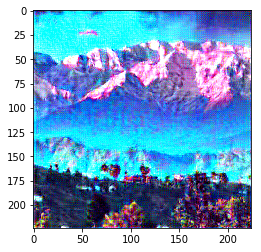

In [50]:
plt.imshow(kk)

In [30]:
result = Image.fromarray(kk)
result.save('hima.jpg')

In [31]:
from PIL import Image

In [43]:
def save_image(path, image):
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)


In [44]:
save_image("hima.jpg",x0)

/home/n/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


ValueError: 'arr' does not have a suitable array shape for any mode.

In [38]:
kk.shape

(224, 224, 3)

In [26]:
x02 = gen.flatten()
art_raw2 = np.clip( ((x02*0.5 + 0.5) * 255.0), a_min=0.0, a_max=255.0 )
kk2 = art_raw2.reshape((224,224,3))
kk2 = kk2.astype('uint8')

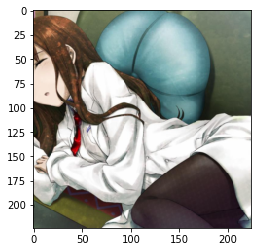

In [27]:
plt.imshow(kk2)

In [39]:
np.sqrt(np.sum(kk2-photo[0,:,:,:]))

4529.3086

In [35]:
photo.shape

(1, 224, 224, 3)

In [23]:
plt.imshow(j[0,:,:,0],cmap="gray")

IndexError: too many indices for array

In [25]:

with tf.Session() as sess:
            
            ###############################
            ## TO DO: 
            ## 1. initialize your variables
            ## 2. create writer to write your graph
    init_fn(sess)
    
    sess.run(tf.global_variables_initializer())
    sess.run(input_image_float.assign(photo))

# For this kind of use case, the limited memory BFGS performs the best
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(total_loss, method='L-BFGS-B',
                                                   options={'maxiter': 30})
#     x_loss, x_grad = sess.run( [total_loss, total_grad])
    global step
    step = 0

    def update(l):
        # Function to print loss
        global step
        if step % 10 == 0:
            print('Step {}; loss {}'.format(step, l))
        step += 1

    optimizer.minimize(session=sess,fetches=[total_loss],loss_callback=update)
    gen = sess.run(input_image_float)
#     o = sess.run(photo)

INFO:tensorflow:Restoring parameters from /home/n/data/inception_v1.ckpt
Step 0; loss 26.67670249938965
Step 10; loss 23.631820678710938
Step 20; loss 13.904537200927734
Step 30; loss 13.567126274108887
Step 40; loss 10.983979225158691
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 3.994272
  Number of iterations: 31
  Number of functions evaluations: 46


In [24]:

### Define loss function and minimise
with tf.Session() as sess:
    # loss function
    L_total  = cl + 5 * sl 
    
    # instantiate optimiser
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(
      L_total, method='L-BFGS-B',
      options={'maxiter': 10})
    
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    sess.run(input_image_float.assign(photo))
    for i in range(1,5):
        # run optimisation
        optimizer.minimize(sess)
        img_output = sess.run(input_image_float)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 4.350934
  Number of iterations: 11
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 3.660701
  Number of iterations: 11
  Number of functions evaluations: 17
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 0.348646
  Number of iterations: 11
  Number of functions evaluations: 14
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 0.147857
  Number of iterations: 11
  Number of functions evaluations: 15


In [19]:
v = gen

In [25]:
img_output.shape

(1, 224, 224, 3)

In [28]:
x0 = img_output.flatten()
art_raw = np.clip( ((x0*0.5 + 0.5) * 255.0), a_min=0.0, a_max=255.0 )
kk = art_raw.reshape((224,224,3))
kk = kk.astype('uint8')

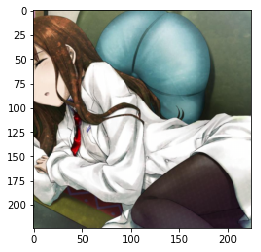

In [29]:
plt.imshow(kk)

In [ ]:
plt.imshow(f)

In [ ]:
t0 = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    init_fn(sess)
    
        # This helper function (to interface with scipy.optimize) must close over sess
#     def eval_loss_and_grad(x):  # x0 is a 3*image_size*image_size float64 vector
#     x_image = x.reshape(1,224,224,3).astype('float32')
#         print(x_image.shape)
    i = 0
    while (i<30):   
        sess.run( [train_step3], feed_dict={input_image_float: j} )
#         x_loss = sess.run(total_loss,feed_dict={input_image_float: j} )
        k = sess.run(input_image_float)
        print(i,x_loss)
        i = i+1
#     f = sess.run()    
#     print("\nEval Loss @ ", [ "%.6f" % l for l in x[100:106]], " = ", x_loss)
            #print("Eval Grad = ", [ "%.6f" % l for l in x_grad.flatten()[100:106]] )

#         losses_ = sess.run( losses, feed_dict={input_image_float: x_image} )
#         print("Eval loss components = ", [ "%.6f" % l for l in losses_])

#         return x_loss.astype('float64'), x_grad.flatten().astype('float64')

#     x0, x0_loss, state = scipy.optimize.fmin_l_bfgs_b( eval_loss_and_grad, photo, maxfun=50,maxiter=500) 
#         iteration += 1

#     print("Iteration %d, in %.1fsec, Current loss : %.4f" % (iteration, float(time.time() - t0), x0_loss))

#     art_raw = np.clip( ((x0*0.5 + 0.5) * 255.0), a_min=0.0, a_max=255.0 )
#     plot_layout( art_raw.reshape(image_size,image_size,3).astype('uint8') )

In [ ]:
# define optimizer (1 line)
optimizer3 = tf.train.AdamOptimizer(1)

# define train_step (1 line)
train_step3 = optimizer3.minimize(total_loss)


In [ ]:
x_loss



In [ ]:
plt.imshow(photo[0,:,:,1])

In [25]:
def generate_noise_image(content_image,noise_ratio=0.6):
    noise_image = np.random.uniform(-20, 20, (1, 224, 224, 3)).astype(np.float32)
    return noise_image * noise_ratio + content_image * (1 - noise_ratio)


In [26]:
j = generate_noise_image(photo)

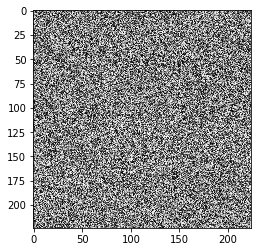

In [27]:
plt.imshow(j[0,:,:,0],cmap="gray")

In [ ]:

def optimize(optimizer, iterations=100, new_image=True):
    ''' Define and run the optimization.
    Args:
        optimizer: The optimizer to use.
        iterations: Number of times to run optimizer.
        new_image: Whether to start with a new image, or continue with the 
            previous one.
    Return: A tuple: 
        A list of losses during the optimization like so: [(time elapsed, loss)]
        The image
    '''
    with graph.as_default():
        # Compute the gradients for a list of variables.
        grads_and_vars = optimizer.compute_gradients(total_grad, [input_tensor])
        # Op that ask the optimizer to apply the gradients.
        train_step = optimizer.apply_gradients(grads_and_vars)

        initialize_variables()
        if new_image:
            init_input()
        losses = run_optimization(
            train_step, iterations=iterations, print_n_times=5)
        result_image = input_tensor.eval()
        result_image = np.clip(deprocess(result_image), 0, 255)
        show(result_image)
        return losses, result_image



In [ ]:


optimizer = tf.train.AdamOptimizer(learning_rate)
loss, result_image = optimize(optimizer)